# Analysis of Data Using PLS and Bootstrap: PISA data
Input dictionary: `dict_results/newvolumes/dict_results_across_mice_PISA_with_Pons.npy`


To create it run the notebook `analysis_PISA.ipynb`

## Overview
This Python script is designed to analyze brain region activity using Partial Least Squares (PLS) analysis, comparing experimental groups based on data related to cell counts, energy levels, and density in different brain regions. The script takes volumetric data, processes it for PLS analysis, and generates statistical output that identifies significant regions across experimental conditions. The script also applies bootstrap testing to assess the robustness of the PLS results and plots the outcomes.

## Workflow Summary
1. **Load Volume Data**: The script loads and cleans a volume database of brain regions.
2. **Set Directories and Load Data**: The root directories and experimental details are defined, followed by loading the results from a precomputed dictionary containing region-specific measurements.
3. **Data Formatting for PLS**: The data is formatted for PLS analysis, focusing on the following:
   - Cell counts (`n_cells`)
   - Energy (`energy`)
   - Density (`density`)
   - Relative density (`relative_density`)

   These datasets are processed, cleaned, and saved as CSV files for later use.
   
4. **PLS Analysis**: The script runs PLS analysis using external Python scripts (`area_pls.py`) on each dataset (cell counts, energy, density, relative density) and saves the salience and contrast results.
   
5. **Plot Results**: It visualizes the contrasts and saliences for each dataset across brain regions, using custom plotting functions.

6. **Identify Significant Areas**: The script identifies brain regions that show significant differences in the PLS analysis across the experimental groups. It highlights overlapping significant regions across different metrics (e.g., cell counts, energy).

7. **Compare Experimental Groups**: In specific sections of the script, the analysis is performed to compare only two experimental groups, excluding the control group, and identifies brain regions with significant differences between familiar and unfamiliar stimuli.

## Key Functions and Steps

- **`ace.clean_volumes_database()`**: Cleans and loads the brain volume database.
- **`upls.reformat_dict_acronym()`**: Reformats the dictionary of results, standardizing brain region acronyms.
- **`upls.format_data_pls()`**: Formats the data for PLS analysis based on the specified batch and data table (cell counts, energy, etc.).
- **PLS Execution**: Calls to external `area_pls.py` scripts run PLS analysis on the prepared datasets.
- **`upls.plot_panel_contrasts()` and `upls.plot_panel_saliences()`**: Plot the contrast and salience data, respectively, for each dataset and experimental condition.
- **`upls.identify_pls_sig_areas()`**: Identifies brain regions that are statistically significant in the PLS analysis based on a threshold value (2.56).

## Outputs
The script produces several outputs:
- CSV files with the formatted data for PLS analysis.
- CSV files containing PLS results for saliences and contrasts.
- Plots for each metric (cell counts, energy, density, relative density) displaying contrasts and saliences across brain regions.
- Lists of significant brain regions, highlighting overlaps between different experimental conditions and metrics.

## Requirements
The script requires several Python libraries, including:
- `numpy`, `pandas`, `matplotlib`, `seaborn` for data manipulation and visualization.
- Custom modules: `analyze_cells_energy`, `utils_PLS`, and `utils` for specific data processing and analysis tasks.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'PISA'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
batch='PISA'

In [5]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_PISA_without_Pons.npy', 
                                   allow_pickle=True).item()

# reformat dictionary and subjects
old_keys = list(dict_results_across_mice.keys())
for key in old_keys:
    group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
    number = key.split('_')[0]
    new_key = 'BL'+number+group
    dict_results_across_mice[new_key] = dict_results_across_mice[key]
    del dict_results_across_mice[key]
    
#remove BL12_noshock due to biased number of cells
del dict_results_across_mice['BL12noshock']
subjects = list(dict_results_across_mice.keys())

In [6]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

In [7]:
dict_results_across_mice.keys()

dict_keys(['BL13noshock', 'BL4demonstrator', 'BL9demonstrator', 'BL2observer', 'BL17demonstrator', 'BL22demonstrator', 'BL1noshock', 'BL20noshock', 'BL19noshock', 'BL16observer', 'BL15noshock', 'BL10observer', 'BL11noshock', 'BL6demonstrator', 'BL7noshock', 'BL14demonstrator', 'BL3demonstrator', 'BL5observer', 'BL18observer', 'BL8observer', 'BL21observer'])

In [8]:
# # remove one group
# removed = []
# for subject in dict_results_across_mice.keys():
#     if subject.split('_')[0] in ['BL'+str(i) for i in range(9,17)]:
#         removed.append(subject)
# for key in removed:
#     del dict_results_across_mice[key]

In [9]:
# dict_results_across_mice.keys()

# Format data for task PLS

In [10]:
data_ncells = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='n_cells')
data_energy = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='energy')
data_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                    batch=batch, table='density')
data_relative_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                             batch=batch, table='relative_density')
data_ncells.dropna(inplace=True, axis=1)
data_energy.dropna(inplace=True, axis=1)
data_density.dropna(inplace=True, axis=1)
data_relative_density.dropna(inplace=True, axis=1)
data_ncells.to_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy.to_csv('./results_pls/'+batch+'_energy.csv')
data_density.to_csv('./results_pls/'+batch+'_density.csv')
data_relative_density.to_csv('./results_pls/'+batch+'_relative_density.csv')

# Format data for hierarchy plotting

In [12]:
df_levels = upls.create_df_levels(volumes, level=8)

# Apply task PLS

In [13]:
%%bash
python area_pls.py -i results_pls/PISA_n_cells.csv -o './results_pls/PISA_ncells'

In [14]:
%%bash
python area_pls.py -i results_pls/PISA_energy.csv -o './results_pls/PISA_energy'

In [15]:
%%bash
python area_pls.py -i results_pls/PISA_density.csv -o './results_pls/PISA_density'

In [16]:
%%bash
python area_pls.py -i results_pls/PISA_relative_density.csv -o './results_pls/PISA_relative_density'

# PLS ncells

In [17]:
contrasts = pd.read_csv('./results_pls/PISA_ncells_contrasts.csv')
saliences = pd.read_csv('./results_pls/PISA_ncells_saliences.csv')
contrasts = contrasts.rename(columns={"group_noshock": "noshock", 
                                      "group_demonstrator": "demonstrator", 
                                      "group_observer":"observer"})

(<Figure size 936x504 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8bec2622e8>,
       dtype=object))

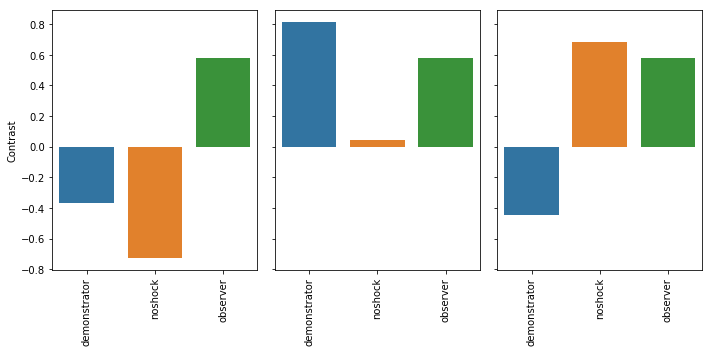

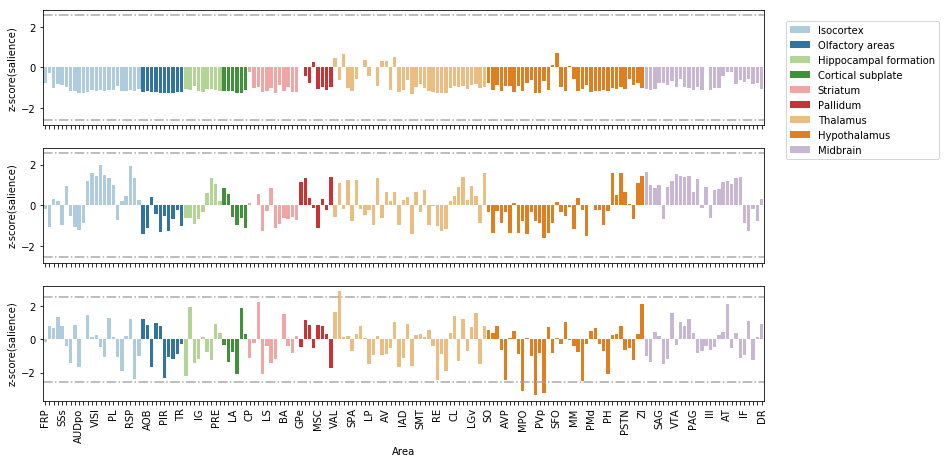

In [18]:
upls.plot_panel_contrasts(batch=batch, variable='ncells')
upls.plot_panel_saliences(batch=batch, variable='ncells', df_levels=df_levels)

# PLS energy

(<Figure size 936x504 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8beaf8b4a8>,
       dtype=object))

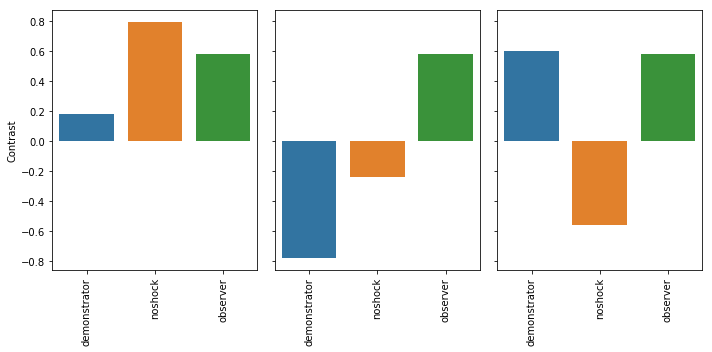

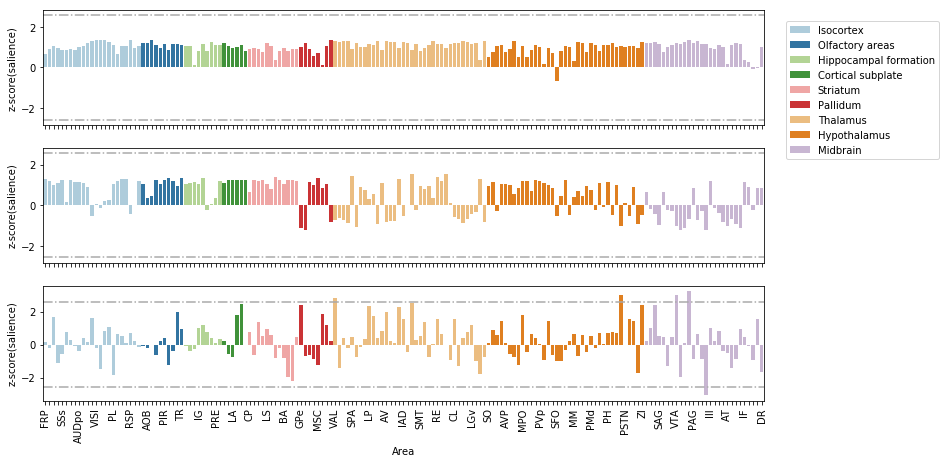

In [19]:
upls.plot_panel_contrasts(batch=batch, variable='energy')
upls.plot_panel_saliences(batch=batch, variable='energy', df_levels=df_levels)


# PLS density

(<Figure size 936x504 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8becb242e8>,
       dtype=object))

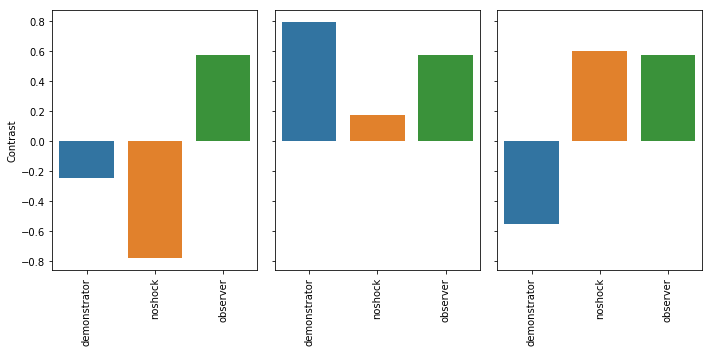

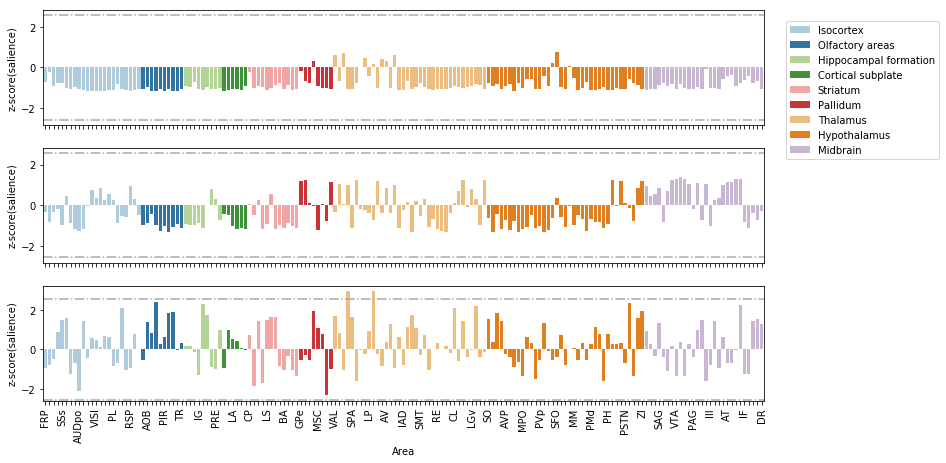

In [20]:
upls.plot_panel_contrasts(batch=batch, variable='density')
upls.plot_panel_saliences(batch=batch, variable='density', df_levels=df_levels)

# PLS relative density

(<Figure size 936x504 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8bdfc5f4e0>,
       dtype=object))

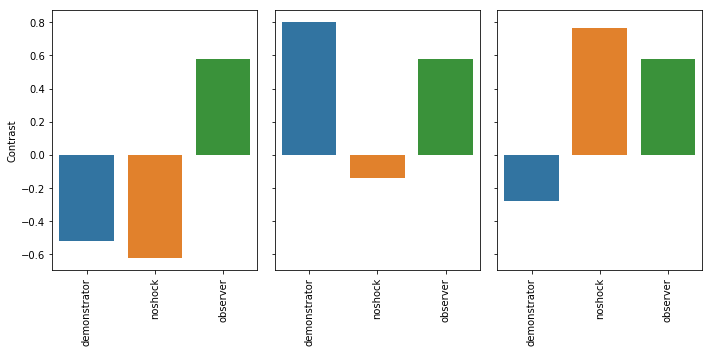

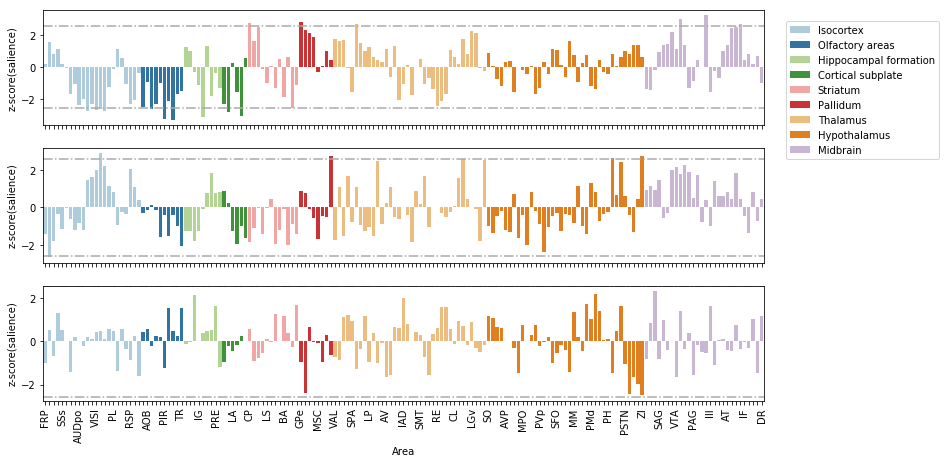

In [21]:
upls.plot_panel_contrasts(batch=batch, variable='relative_density')
upls.plot_panel_saliences(batch=batch, variable='relative_density', df_levels=df_levels)

# Identify areas with significant area contribution

In [22]:
batch='PISA'
overlap = {'ncells':[], 'energy':[], 'density':[], 'relative_density':[]}
for variable in overlap.keys():
    overlap[variable] = set(upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=1.96, 
                                           volumes=volumes))
[len(overlap[key]) for key in overlap.keys()]

[18, 16, 11, 56]

In [23]:
overlap['relative_density']

{'Anterior olfactory nucleus',
 'Anterolateral visual area',
 'Anteromedial visual area',
 'Basomedial amygdalar nucleus',
 'Bed nucleus of the anterior commissure',
 'Caudoputamen',
 'Central amygdalar nucleus',
 'Claustrum',
 'Cortical amygdalar area',
 'Endopiriform nucleus',
 'Entorhinal area',
 'Fasciola cinerea',
 'Fundus of striatum',
 'Globus pallidus external segment',
 'Globus pallidus internal segment',
 'Interanterodorsal nucleus of the thalamus',
 'Interanteromedial nucleus of the thalamus',
 'Intercalated amygdalar nucleus',
 'Lateral habenula',
 'Lateral hypothalamic area',
 'Lateral terminal nucleus of the accessory optic tract',
 'Lateral visual area',
 'Main olfactory bulb',
 'Midbrain reticular nucleus',
 'Midbrain reticular nucleus retrorubral area',
 'Nucleus of reuniens',
 'Nucleus of the brachium of the inferior colliculus',
 'Nucleus of the lateral olfactory tract',
 'Pedunculopontine nucleus',
 'Peripeduncular nucleus',
 'Periventricular hypothalamic nucleus pr

# Task PLS only on two groups: Observer e demonstrator

In [24]:
relative_density_obs_dem = pd.concat([data_relative_density.groupby('group').get_group('observer'),
          data_relative_density.groupby('group').get_group('demonstrator')])
relative_density_obs_dem.dropna(inplace=True, axis=1)
batch = 'PISA_obs_dem'
relative_density_obs_dem.to_csv('./results_pls/'+batch+'_relative_density.csv')

In [25]:
%%bash
python area_pls.py -i results_pls/PISA_obs_dem_relative_density.csv -o './results_pls/PISA_obs_dem_relative_density'

(<Figure size 936x504 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8bd80bdcc0>,
       dtype=object))

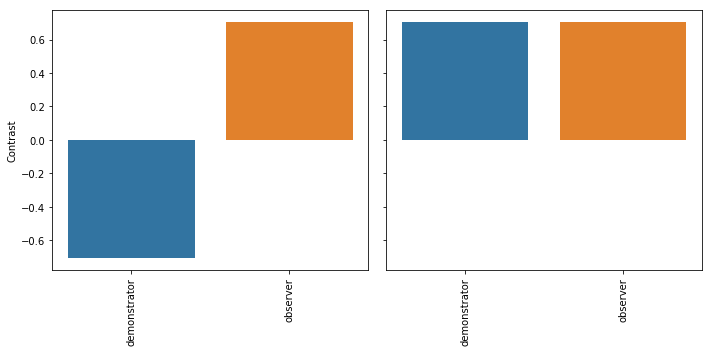

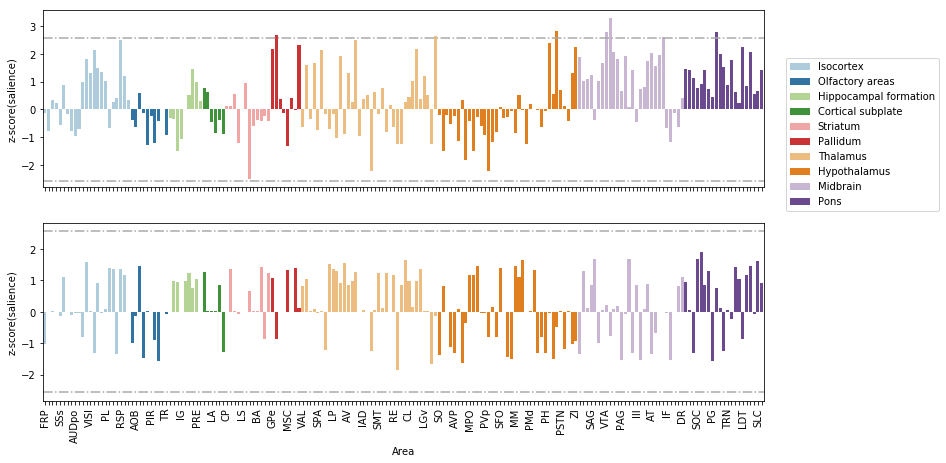

In [26]:
upls.plot_panel_contrasts(batch=batch, variable='density')
upls.plot_panel_saliences(batch=batch, variable='density', df_levels=df_levels)

In [27]:
variable='relative_density'
observer_vs_demonstrator = upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=2.56, 
                                           volumes=volumes)

In [28]:
overlap['relative_density']

{'Anterior olfactory nucleus',
 'Anterolateral visual area',
 'Anteromedial visual area',
 'Basomedial amygdalar nucleus',
 'Bed nucleus of the anterior commissure',
 'Caudoputamen',
 'Central amygdalar nucleus',
 'Claustrum',
 'Cortical amygdalar area',
 'Endopiriform nucleus',
 'Entorhinal area',
 'Fasciola cinerea',
 'Fundus of striatum',
 'Globus pallidus external segment',
 'Globus pallidus internal segment',
 'Interanterodorsal nucleus of the thalamus',
 'Interanteromedial nucleus of the thalamus',
 'Intercalated amygdalar nucleus',
 'Lateral habenula',
 'Lateral hypothalamic area',
 'Lateral terminal nucleus of the accessory optic tract',
 'Lateral visual area',
 'Main olfactory bulb',
 'Midbrain reticular nucleus',
 'Midbrain reticular nucleus retrorubral area',
 'Nucleus of reuniens',
 'Nucleus of the brachium of the inferior colliculus',
 'Nucleus of the lateral olfactory tract',
 'Pedunculopontine nucleus',
 'Peripeduncular nucleus',
 'Periventricular hypothalamic nucleus pr

In [29]:
len(set(observer_vs_demonstrator).intersection(overlap['relative_density']))

11

In [30]:
observer_vs_demonstrator

array(['Basolateral amygdalar nucleus',
       'Bed nucleus of the anterior commissure',
       'Globus pallidus external segment',
       'Globus pallidus internal segment', 'Lateral habenula',
       'Lateral hypothalamic area', 'Medial septal complex',
       'Midbrain reticular nucleus retrorubral area',
       'Posterior limiting nucleus of the thalamus',
       'Postpiriform transition area', 'Preparasubthalamic nucleus',
       'Reticular nucleus of the thalamus', 'Zona incerta'], dtype='<U43')